### <mark>Setup paths</mark>

Launch ltspice docker
- cd ltspice_docker
- ./start.sh

In [1]:
# Add folder containing scripts to the path
import sys
sys.path.append('../') ## Change accordingly

# Command to execute LTSpice launch
LTSPICE_INSTANCE = "../../ltspice.sh" ## Change accordingly
HSPICE_INSTANCE = "../../hspice.sh" ## Change accordingly

In [2]:
# Store relative path from ltspice docker to current directory
import os
from pathlib import Path

ltspice_absolute = os.path.realpath(LTSPICE_INSTANCE)
ltspice_dir = os.path.dirname(ltspice_absolute)
notebook_dir = os.getcwd()

CURRENT_FOLDER = Path(notebook_dir).relative_to(ltspice_dir)
print("CURRENT_FOLDER:", CURRENT_FOLDER)

# Reload libraries automatically if is being changed on the fly
%load_ext autoreload
%autoreload 2

CURRENT_FOLDER: files/crossbar_noise_analysis


### <mark>Runtime parameters</mark>


In [11]:
# Support cba_size specified in command line
import argparse
parser = argparse.ArgumentParser()
parser.add_argument('--cba_size', type=int, required=False)
parser.add_argument('--mc', type=str, default='0.22361') # Tolerance of 0.05 (5%) variance
args, extra = parser.parse_known_args()

print("Using monte carlo variance:", args.mc)

if hasattr(args, 'cba_size'):
    # If specified in command line, then use it instead
    cba_size = (args.cba_size, 1)
    print("Specified CBA size:", cba_size)
else:
    # Logic to choose counter
    try:
        run_all_counter += 1
    except NameError:
        run_all_counter = 0
    print("Counter:", run_all_counter)

    # Select size of CBA based on counter
    my_sizes = [2, 4, 8, 12, 16, 24, 32, 48, 64, 80, 96, 128, 256, 384, 512, 768, 960,]
    cba_size = (my_sizes[run_all_counter], 1)
    print("Selecting CBA size:", cba_size)

# Iterate less as the size of CBA goes up
iterations = 128 #max(1, 1024 // my_sizes[run_all_counter])

# Time for script to run
import time
script_start_time = time.time()

['/usr/lib/python3/dist-packages/ipykernel_launcher.py', '-f', '/home/zst/.local/share/jupyter/runtime/kernel-9c9fe50b-63bb-41a5-99b6-3e9982c0627f.json']
Counter: 3
Selecting CBA size: (12, 1)


In [4]:
CELL_PARAMETERS = {
    'states':    [100000, 10000], # Order from HRS to LRS
    'filename':  'cell_subcircuit',
    'tolerance': args.mc, # Tolerance of 0.05 (5%) variance
}

CBA1_PARAMETERS = {
    'wordline':  cba_size[0], # inputs
    'bitline':   cba_size[1], # outputs
    'filename':  'cba1_subcircuit',
    'cell': CELL_PARAMETERS['filename'],
}

WRAPPER_PARAMETERS = {
    'wordline':  CBA1_PARAMETERS['wordline'], # input
    'bitline':   CBA1_PARAMETERS['bitline'], # output
    'filename':  'noisy_cba_subcircuit',
}

SIM_PARAMETERS = {
    'exe':       LTSPICE_INSTANCE,
    'dir':       CURRENT_FOLDER,
    'spice':     'ltspice', # or hspice
}


### <mark>Generate subcircuits</mark>

In [5]:
import generator as gen
import simulator as sim

def copy_ltspice_template(thesrcfile, thedestfile):
    !cp {thesrcfile}.asc {thedestfile}.asc
    !cp {thesrcfile}.asy {thedestfile}.asy

# Cell
gen.generate_cell(resistance_states=CELL_PARAMETERS['states'],
                  cell_subcircuit=CELL_PARAMETERS['filename'])

# Modify cell to add Monte Carlo tolerances
with open(CELL_PARAMETERS['filename'] + '.asc', "r") as f:
    contents = f.read()

with open(CELL_PARAMETERS['filename'] + '.asc', "w") as f:
    contents = contents.replace("{resistance}",
       "{mc(resistance, tol)}".replace('tol', str(CELL_PARAMETERS['tolerance'])), 1)
    f.write(contents)

# CBA1
gen.generate_cba(wordline=CBA1_PARAMETERS['wordline'],
                 bitline=CBA1_PARAMETERS['bitline'],
                 filename=CBA1_PARAMETERS['filename'],
                 cell_subcircuit=CBA1_PARAMETERS['cell'])

# Simulation parameters
sim.set_ltspice(exe=LTSPICE_INSTANCE, dir=CURRENT_FOLDER)

In [6]:
thefile = str(CURRENT_FOLDER) + '/' + CELL_PARAMETERS['filename'] + '.asc'
#!$LTSPICE_INSTANCE $thefile

In [7]:
thefile = str(CURRENT_FOLDER) + '/' + CBA1_PARAMETERS['filename'] + '.asc'
#!$LTSPICE_INSTANCE $thefile

### <mark>Generate wrapper</mark>


In [8]:
#iterations = 50
def generate_feedforward_circuit():
    # Header
    entries = []
    entries.clear()
    entries.append("Version 4")
    entries.append("SHEET 1 880 680")
    entries.append("TEXT 64 -96 LEFT 2 !.tran 0m 1m 0m")
    text = f"Generated on {gen.getdate()}"
    entries.append(f"TEXT 64 -128 Left 2 ;{text}")

    entries.append(f"TEXT 64 -64 Left 2 !.step param N 1 {iterations} 1")

    def add_flag(name, x, y):
        entries.append(f"FLAG {int(x)} {int(y)} {name}")
        entries.append(f"IOPIN {int(x)} {int(y)} BiDir")

    def add_voltage_with_gnd(name, value, x, y):
        entries.append(f"SYMBOL voltage {int(x)} {int(y)} R0")
        entries.append(f"WINDOW 0 24 16 Left 0")  # Smaller InstName text
        entries.append(f"WINDOW 3 24 96 Left 0")  # Smaller Value text
        entries.append(f"SYMATTR InstName V.{name}")
        entries.append(f"SYMATTR Value {value}")
        entries.append(f"FLAG {int(x)} {int(y+16)} {name}")
        entries.append(f"IOPIN {int(x)} {int(y+16)} BiDir")
        entries.append(f"FLAG {int(x)} {int(y+96)} 0")

    def add_crossbar_with_labels(instname, cba_params, x, y, wordline_labels, bitline_labels):
        GRID_X = 16*2
        GRID_Y = 16*2
        OFFSET_X = -1*16*5
        OFFSET_Y = +1*16*5
        filename = cba_params['filename']
        entries.append(f"SYMBOL {filename} {x} {y} R0")
        entries.append(f"SYMATTR InstName {instname}")
        entries.append(f"SYMATTR SpiceLine <{instname}_PARAMS>")

        for c in range(cba_params['bitline']):
            label = bitline_labels[c]
            add_flag(label, x=x+c*GRID_X, y=y+OFFSET_Y)

        for r in range(cba_params['wordline']):
            label = wordline_labels[r]
            add_flag(label, x=x+OFFSET_X, y=y+(-r*GRID_Y))

    def add_neuron_with_labels(instname, neuron_params, x, y, sig_in, out_pos, out_neg):
        filename = neuron_params['filename']
        entries.append(f"SYMBOL {filename} {x} {y} R0")
        entries.append(f"SYMATTR InstName {instname}")
        add_flag(name=sig_in,  x=x+0, y=y+0)
        add_flag(name=out_pos, x=x+0, y=y+32)
        add_flag(name=out_neg, x=x+0, y=y+64)

    # Input voltage sources
    GRID_V = 16*6
    for i in range(CBA1_PARAMETERS['wordline']):
        label = f"WORD1.p{i}"
        value = f"<INPUT.p{i}>"
        add_voltage_with_gnd(name=label, value=value,
                             x=i*GRID_V, y=-600)
        # label = f"WORD1.n{i}"
        # value = f"<INPUT.n{i}>"
        # add_voltage_with_gnd(name=label, value=value,
        #                      x=i*GRID_V, y=-300)
    
    for i in range(CBA1_PARAMETERS['bitline']):
        label = f"BIT1.{i}"
        value = f"<OUTPUT.{i}>"
        add_voltage_with_gnd(name=label, value=value,
                             x=i*GRID_V, y=-900)

    # Dual CBA1
    CBA1_YREF = 0 + CBA1_PARAMETERS['wordline'] * (16*2) # vertical
    CBA1_XREF = 400 + CBA1_PARAMETERS['bitline'] * (16*2) # horizontal
    add_crossbar_with_labels("CBA1.p", CBA1_PARAMETERS, 0, CBA1_YREF, 
        wordline_labels = [f"WORD1.p{i}" for i in range(CBA1_PARAMETERS['wordline'])],
        bitline_labels = [f"BIT1.{i}" for i in range(CBA1_PARAMETERS['bitline'])]
    )
    # add_crossbar_with_labels("CBA1.n", CBA1_PARAMETERS, CBA1_XREF, CBA1_YREF, 
    #     wordline_labels = [f"WORD1.n{i}" for i in range(CBA1_PARAMETERS['wordline'])],
    #     bitline_labels = [f"BIT1.{i}" for i in range(CBA1_PARAMETERS['bitline'])]
    # )

    # Write to file
    with open(WRAPPER_PARAMETERS['filename'] + '.asc', "w") as f:
        content = '\n'.join(entries)
        f.write(content)

generate_feedforward_circuit()

In [9]:
# Preview wrapper
thefile = str(CURRENT_FOLDER) + '/' + WRAPPER_PARAMETERS['filename'] + '.asc'
#!$LTSPICE_INSTANCE $thefile

### <mark>Convert to netlists</mark>


In [10]:
sim.convert_ltspice_sch_to_netlist(filename=WRAPPER_PARAMETERS['filename'])
# !ls *.net

009e:err:menubuilder:Process_Link unable to load L"C:\\users\\appuser\\Recent\\neuron_tanh_compare_matching2.asc.lnk"
009e:err:menubuilder:wWinMain failed to build menu item for L"C:\\users\\appuser\\Recent\\neuron_tanh_compare_matching2.asc.lnk"
01b6:err:menubuilder:Process_Link unable to load L"C:\\users\\appuser\\Recent\\neuron_tanh_distribution.asc.lnk"
01b6:err:menubuilder:wWinMain failed to build menu item for L"C:\\users\\appuser\\Recent\\neuron_tanh_distribution.asc.lnk"


noisy_cba_subcircuit.hspice.net  noisy_cba_subcircuit_tmp8.net
noisy_cba_subcircuit.net


### <mark>Simulate</mark>


In [11]:
# Override functions in the abstraction layer to handle two CBAs
import ltspice # pip3 install ltspice
import numpy as np

def my_handle_param_sub(content, _wl_, _bl_, io):
    print("[my_handle_param_sub]")

    # Inputs
    for i, value in enumerate(io['INPUT.p']):
        content = content.replace(f"<INPUT.p{i}>", str(value))

    for i, value in enumerate(io['INPUT.n']):
        content = content.replace(f"<INPUT.n{i}>", str(value))

    for i, value in enumerate(io['OUTPUT.']):
        content = content.replace(f"<OUTPUT.{i}>", str(value))

    # CBA weights helper
    def create_cba_param(io_g_item):
        cba_params = []
        for r in range(len(io_g_item)):
            for c in range(len(io_g_item[r])):
                label = f"G{r}.{c}"
                value = str(int(io_g_item[r][c]))
                cba_params.append(f"{label}={value}")
        return " ".join(cba_params)

    # CBA1
    content = content.replace("<CBA1.p_PARAMS>", create_cba_param(io['CBA1.p']))
    content = content.replace("<CBA1.n_PARAMS>", create_cba_param(io['CBA1.n']))

    return content

def my_handle_result_sub(_wl_, _bl_, get_data):
    labels = []
    # After CBA1
    labels += [f'I(V.BIT1.{i})' for i in range(CBA1_PARAMETERS['bitline'])]

    # LTspice parser
    # Retrieve all repetitions of monte carlo runs
    netlist = WRAPPER_PARAMETERS['filename']; tmp_id = 8
    tmp_filename = f"{netlist}_tmp{tmp_id}"
    l = ltspice.Ltspice(tmp_filename + '.raw')
    l.parse()
    def _custom_get_data(label):
        list_of_cases = []
        for i in range(iterations):
            datapoint = l.get_data(label, case=i)[-1]
            list_of_cases.append(datapoint)
        return list_of_cases
        
    # Results
    result = {}
    for label in labels:
        data = _custom_get_data(label)
        result[label] = (data)
        #print(label, data)
        # if data is None: # Store latest only
        #     result[label] = (data)
        # else:
        #     result[label] = (data[-1])

    return {
        'output_voltage': result,
    }

sim.handle_param_sub = my_handle_param_sub
sim.handle_result_sub = my_handle_result_sub

In [12]:
INPUT_vector = np.ones(CBA1_PARAMETERS['wordline'])
CBA1_states = np.zeros((CBA1_PARAMETERS['wordline'], CBA1_PARAMETERS['bitline']))

io = {
    'INPUT.p': np.array(INPUT_vector)*+1,
    'INPUT.n': [],
    'OUTPUT.': [0]*CBA1_PARAMETERS['bitline'],
    'CBA1.p': np.multiply(CBA1_states > 0, CBA1_states*+1),
    'CBA1.n': np.multiply(CBA1_states < 0, CBA1_states*-1),
}

result = sim.simulate_netlist(
    wordline=None, bitline=None, io=io,
    netlist=WRAPPER_PARAMETERS['filename'],
    tmp_id=8
)

print('[output_voltage]')
for key, val in result['output_voltage'].items():
    print(key)
    #print(key, val)


[my_handle_param_sub]


0099:err:menubuilder:Process_Link unable to load L"C:\\users\\appuser\\Recent\\neuron_tanh_compare_matching2.asc.lnk"
0099:err:menubuilder:wWinMain failed to build menu item for L"C:\\users\\appuser\\Recent\\neuron_tanh_compare_matching2.asc.lnk"
01c8:err:menubuilder:Process_Link unable to load L"C:\\users\\appuser\\Recent\\neuron_tanh_distribution.asc.lnk"
01c8:err:menubuilder:wWinMain failed to build menu item for L"C:\\users\\appuser\\Recent\\neuron_tanh_distribution.asc.lnk"


> Simulation done using ltspice
> Parsing ltspice results
[output_voltage]
I(V.BIT1.0)


### <mark>Plot Graph</mark>


In [13]:
%matplotlib inline
#%config InlineBackend.figure_formats = ['svg']
from scipy.stats import norm
import matplotlib.pyplot as plt

def plot_graph(data, id_name):
    # Fit a normal distribution to the data:
    mu, std = norm.fit(data)

    # Plot the histogram.
    plt.hist(data, bins=30, density=True, alpha=1.0, color='m')

    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2, label="Distribution")
    title = f"CBA size: {id_name}\n"
    title += "Fit results: mu = %e,  std = %e" % (mu, std)
    plt.title(title)
    # draw vertical line
    plt.vlines(x=mu, ymin=0, ymax=max(p), colors='k')
    plt.legend()
    plt.savefig(f"plot_{id_name}.png")
    plt.show()
    
    return (mu, std)


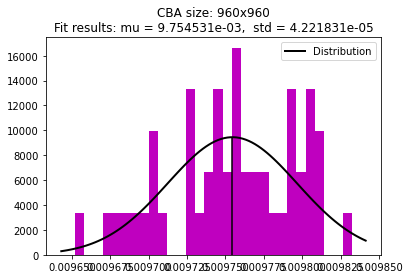

CBA size: 960, Mean: 0.00975453108549118, SD: 4.221830749884248e-05, Time: 652.1794822216034, 


In [14]:
# Flatten list of list into a single list
mydata = sum(result['output_voltage'].values(), [])
# Normalise to expected output
mydata = list(map(lambda x: x, mydata))
# Identifier
cba_id = f"{cba_size[0]}x{cba_size[0]}"
# Plot graph
mu, std = plot_graph(mydata, cba_id)
# Timer
script_time_taken = time.time() - script_start_time
# Write results
output = f"CBA size: {cba_size[0]}, "
output += f"Mean: {mu}, "
output += f"SD: {std}, "
output += f"Time: {script_time_taken}, "
print(output)

# Format: CBA size, Mean, SD, Time,
output = f"{cba_size[0]}, {mu}, {std}, {script_time_taken}, "
with open("cba_distribution_results.txt", "a") as f:
    f.write(output + '\n')


In [15]:
thefile = str(CURRENT_FOLDER) + '/' + WRAPPER_PARAMETERS['filename'] + '_tmp8.net'
#!$LTSPICE_INSTANCE $thefile

In [16]:
# Test parsing of LTspice data
if False:
    netlist = WRAPPER_PARAMETERS['filename']
    tmp_id = 8
    tmp_filename = f"{netlist}_tmp{tmp_id}"
    l = ltspice.Ltspice(tmp_filename + '.raw')
    l.parse()
    def _custom_get_data(label):
        for i in range(iterations):
            print("_custom_get_data:", label, l.get_data(label, case=i))
        return l.get_data(label, case=0)

    _custom_get_data("I(V.BIT1.0)")

### <mark>Cleanup</mark>

In [17]:
# Create folder for deletion
thedatetime =  __import__("datetime").datetime.now().strftime("%Y%m%d_%H%M")
thefolder = "delete_" + thedatetime
!mkdir -v -p {thefolder}

def delete_helper(thefile, debug=False):
    if not debug:
        !mv {thefile} {thefolder}
    else:
        !ls {thefile}

# Cell
delete_helper(CELL_PARAMETERS['filename'] + ".asc")
delete_helper(CELL_PARAMETERS['filename'] + ".asy")
# CBA1
delete_helper(CBA1_PARAMETERS['filename'] + ".asc")
delete_helper(CBA1_PARAMETERS['filename'] + ".asy")
# Wrapper
delete_helper(WRAPPER_PARAMETERS['filename'] + ".asc")
# Simulation temporary files
delete_helper("*_tmp*")
delete_helper("*.net*")
# LTSpice temporary files
delete_helper("*.log *.plt *.raw")


mkdir: created directory 'delete_20230224_1057'
mv: cannot stat '*.log': No such file or directory
mv: cannot stat '*.plt': No such file or directory
mv: cannot stat '*.raw': No such file or directory


The End